In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import array

#1

Classification Problem:  Our goal is to employ machine learning (ML) methods to forecast, diagnose, and manage chronic kidney disease (CKD). We are given a wide range of variables in the data including age and whether the patient has certian conditoins like anemia or coronary artery disease. We will build models that use these variables to best predict whether a given patient will have chronic kidney disease. We are given the target variable 'class' which specifies whether the patient has chronic kidney disease or not.

#2

Variable Transformation:
By looking out the output, we can see that the hypertension, diabetes mellitus, coronary artery disease, appetite, pedal edema, anemia are all supposed to be of type binary. In the dataset however, the input for these columns are written as yes or no, good or poor. We need to convert these into binary types. Furthermore, we also see that red blood cells, pus cell, pus cell clumps and bacteria have the same problem, as well as the Target, which should defintely be a binary number. We need to convert these categorical type variables into binary variables so that the machine learning algorithms can better understand them, and use the data.


In [3]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# Fetch dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# Create pandas DataFrame for features (X)
X = pd.DataFrame(data=chronic_kidney_disease.data.features, columns=chronic_kidney_disease.feature_names)

# Create pandas DataFrame for targets (y)
y = pd.DataFrame(data=chronic_kidney_disease.data.targets, columns=["class"])

# Combining features and targets into a single DataFrame
data = pd.concat([X, y], axis=1)

# Clean column names for categorical variable "dm" (diabetes mellitus)
data['dm'] = data['dm'].replace(['\tno', 'no'], 'no')
data['dm'] = data['dm'].replace(['yes'], 'yes')

# Clean column for categorical variables "rbc"
# Replace missing values with the mode of the column (mode imputation). This allows for easy categorical to binary conversion.
data['rbc'].fillna("normal", inplace=True)

# Clean column names for target variable "class"
data['class'] = data['class'].replace(['ckd\t', 'notckd'], 'notckd')
data['class_ckd'] = (data['class'] == 'ckd').astype(int)  # Create binary column indicating presence of CKD

# Drop original "class" column
data.drop('class', axis=1, inplace=True)

# Create binary columns for each remaining categorical variable
data_with_dummies = pd.get_dummies(data, columns=["rbc", "pc", "pcc", "ba", "htn", "dm", "cad", "appet", "pe", "ane"], drop_first=True, dtype=int)

print(data_with_dummies.dtypes)


age            float64
bp             float64
sg             float64
al             float64
su             float64
bgr            float64
bu             float64
sc             float64
sod            float64
pot            float64
hemo           float64
pcv            float64
wbcc           float64
rbcc           float64
class_ckd        int32
rbc_normal       int32
pc_normal        int32
pcc_present      int32
ba_present       int32
htn_yes          int32
dm_yes           int32
cad_yes          int32
appet_poor       int32
pe_yes           int32
ane_yes          int32
dtype: object


#3

After the data transformation, we have a dataset that comprises of 14 continuous float and 11 integer binary type variables. We also note that the data has 400 observations. When we look at the summary statistics, we see that the counts for each of the variables are all different. This indicates the presence of missing values. We also see a wide range of values, for example the sugar variable (su) has values ranging from 5 to 351. We also see that blood glucose random has a high standard deviation of 79, which indicates high variability. Lastly, we take a look at the distribution of the class variable. We see 248 instances of potential for kidney risk and 152 instances of no potential for kidney risk.

    age    bp     sg   al   su    bgr    bu   sc    sod  pot  ...  rbc_normal  \
0  48.0  80.0  1.020  1.0  0.0  121.0  36.0  1.2    NaN  NaN  ...           1   
1   7.0  50.0  1.020  4.0  0.0    NaN  18.0  0.8    NaN  NaN  ...           1   
2  62.0  80.0  1.010  2.0  3.0  423.0  53.0  1.8    NaN  NaN  ...           1   
3  48.0  70.0  1.005  4.0  0.0  117.0  56.0  3.8  111.0  2.5  ...           1   
4  51.0  80.0  1.010  2.0  0.0  106.0  26.0  1.4    NaN  NaN  ...           1   

   pc_normal  pcc_present  ba_present  htn_yes  dm_yes  cad_yes  appet_poor  \
0          1            0           0        1       1        0           0   
1          1            0           0        0       0        0           0   
2          1            0           0        0       1        0           1   
3          0            1           0        1       0        0           1   
4          1            0           0        0       0        0           0   

   pe_yes  ane_yes  
0       0        

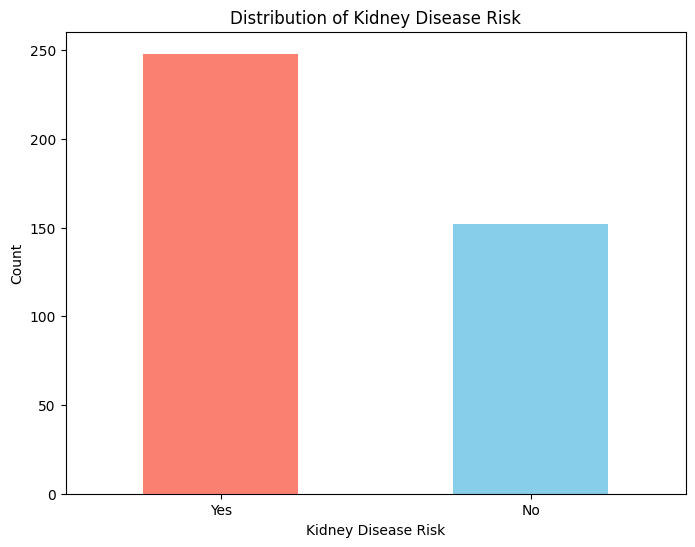

In [4]:
# Data Set Overview
print(data_with_dummies.head())
print(data_with_dummies.dtypes)
print(data_with_dummies.shape)
print("\nSummary Statistics:")
print(data_with_dummies.describe())

missing_values = data_with_dummies.isnull().sum()
print(missing_values)
print(data.shape)


# Count occurrences of each category
ckd_counts = data_with_dummies['class_ckd'].value_counts()

print(ckd_counts)

# Plotting
plt.figure(figsize=(8, 6))
ckd_counts.plot(kind='bar', color=['salmon', 'skyblue'])  # Swapped color order
plt.title('Distribution of Kidney Disease Risk')
plt.xlabel('Kidney Disease Risk')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Yes', 'No'], rotation=0)  # Swapped labels
plt.show()

#4

Association between variables: By looking at the below heatmap we see that places of darker red or darker blue show greater correlation between the two variables. We see that the sugar variable is positively correlated to the blood glucous random variable. Intuitively this makes sense. Given the known association between diabetes and kidney disease, further exploring the relationship between blood glucose and sugar levels could be important. We can also look at the binary variable 'dm_yes' that indicates the presence of diabetes in the patient or not. We see positive correlation between diabetes and hypertension, meaning if someone has diabetes, there is a higher chance they also have hypertension. Naturally, there is also positive correlation between diabetes indication and sugar and glucouse levels. We also see strong positive correlation between hemoglobin and packed cell volume. As we have more blood cells, we have more hemoglobin, so this correlation makes sense. We also note that the blood urea variable is a common biomarker for reflecting kidney function. We note that it is negatively correlated to hemoglobin, packed cell volume, and red blood cell count, and positvely correlated to sugar levels. We might be able to leverage this relationship in our feature selection and model building.

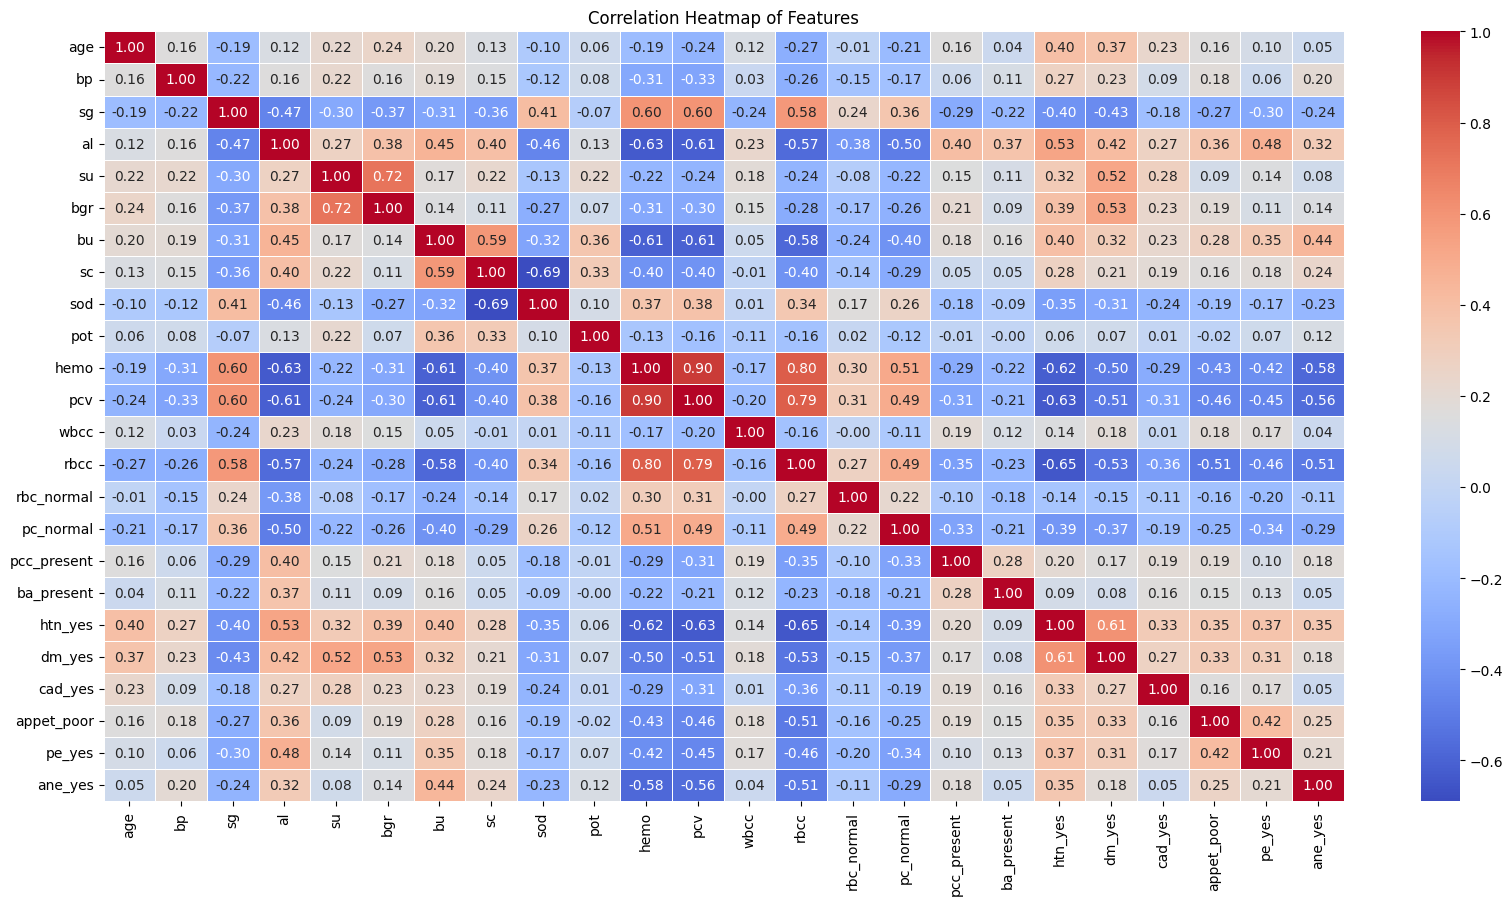

In [13]:
# Association between variables
import seaborn as sns

# remove'class'
data_with_dummies_excluded = data_with_dummies.drop(['class_ckd'], axis=1)

# correlation matrix
correlation_matrix = data_with_dummies_excluded.corr()

# correlation heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Features')
plt.show()



#5

Missing Values: We see in the original data, that the binary columns have a low number of missing values, except for rbc. For these missing binary values, we have handled these in step 1. For all other columns except for rbc, we assign the missing values a value of 0. This change should not be very significant as there is only a few cases of missing values in these variables.

In [6]:
import pandas as pd
from ucimlrepo import fetch_ucirepo

# fetch dataset
chronic_kidney_disease = fetch_ucirepo(id=336)

# create pandas DataFrame for features (X)
X = pd.DataFrame(data=chronic_kidney_disease.data.features, columns=chronic_kidney_disease.feature_names)

# create pandas DataFrame for targets (y)
y = pd.DataFrame(data=chronic_kidney_disease.data.targets, columns=["class"])

# Combining features and targets into a single DataFrame
data = pd.concat([X, y], axis=1)

missing_values = data.isnull().sum()
print(missing_values)
print(data.shape)



age        9
bp        12
sg        47
al        46
su        49
rbc      152
pc        65
pcc        4
ba         4
bgr       44
bu        19
sc        17
sod       87
pot       88
hemo      52
pcv       71
wbcc     106
rbcc     131
htn        2
dm         2
cad        2
appet      1
pe         1
ane        1
class      0
dtype: int64
(400, 25)


We see that the variables with the most missing values are red blood cell = 152, white blood cell count = 106, and red blood cell count = 131. In question 2, before transforming the data we have to handle the missing values for rbc. We use mode imputation to do this. We see that the most occuring value is normal rbc. We see that 12% of the data is abnormal rbc, and 38% of the data is missing. 

In [14]:
# Count occurrences of each category
rbc_counts = data['rbc'].value_counts()
print(rbc_counts)

rbc_normal_counts = data_with_dummies['rbc_normal'].value_counts()
print(rbc_normal_counts)



rbc
normal      201
abnormal     47
Name: count, dtype: int64
rbc_normal
1    353
0     47
Name: count, dtype: int64


Now we can look at the missing values in the transformed data.

In [8]:
missing_values = data_with_dummies.isnull().sum()
print(missing_values)
print(data_with_dummies.shape)


# Count the number of missing values in each row
missing_values_per_row = data_with_dummies.isnull().sum(axis=1)

# Count the total number of rows with missing values
total_rows_with_missing_values = (missing_values_per_row > 0).sum()

print("Total rows with missing values:", total_rows_with_missing_values)


age              9
bp              12
sg              47
al              46
su              49
bgr             44
bu              19
sc              17
sod             87
pot             88
hemo            52
pcv             71
wbcc           106
rbcc           131
class_ckd        0
rbc_normal       0
pc_normal        0
pcc_present      0
ba_present       0
htn_yes          0
dm_yes           0
cad_yes          0
appet_poor       0
pe_yes           0
ane_yes          0
dtype: int64
(400, 25)
Total rows with missing values: 197


We see that 197 out of 400 rows have missing values. We use soft imputation. We want to be able to capture complex relationships and dependancies. We also want to minimize the amount of bias in our data that can come from imputing with a single point, especially since there are many rows of missing values. Before we perform imputation we need to check if we should scale our data.

In [9]:
print(data_with_dummies.mean())
print(data_with_dummies.var())


age              51.483376
bp               76.469072
sg                1.017408
al                1.016949
su                0.450142
bgr             148.036517
bu               57.425722
sc                3.072454
sod             137.528754
pot               4.627244
hemo             12.526437
pcv              38.884498
wbcc           8406.122449
rbcc              4.707435
class_ckd         0.620000
rbc_normal        0.882500
pc_normal         0.647500
pcc_present       0.105000
ba_present        0.055000
htn_yes           0.367500
dm_yes            0.342500
cad_yes           0.085000
appet_poor        0.205000
pe_yes            0.190000
ane_yes           0.150000
dtype: float64
age            2.947991e+02
bp             1.872419e+02
sg             3.267971e-05
al             1.829740e+00
su             1.208221e+00
bgr            6.285590e+03
bu             2.550554e+03
sc             3.296053e+01
sod            1.083421e+02
pot            1.020102e+01
hemo           8.483161e+00
pc

We must scale the data since wbcc has a mean of 8406 which is much higher than the others. We must scale our data, but we have to exclude the binary variables since there are encoded with a 1 or 0.

In [10]:
from sklearn.preprocessing import StandardScaler

# Extract continuous variables from the DataFrame
continuous_column_names = ['age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc']
continuous_data = data_with_dummies[continuous_column_names]

# Initialize StandardScaler
scaler = StandardScaler()

# Scale the continuous variables
scaled_continuous_data = scaler.fit_transform(continuous_data)

# Create a DataFrame with scaled continuous variables and original binary variables
scaled_data = pd.DataFrame(scaled_continuous_data, columns=continuous_column_names, index=data_with_dummies.index)
scaled_data[['class_ckd', 'rbc_normal', 'pc_normal', 'pcc_present', 'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor', 'pe_yes', 'ane_yes']] = data_with_dummies[['class_ckd', 'rbc_normal', 'pc_normal', 'pcc_present', 'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor', 'pe_yes', 'ane_yes']]



In [11]:
from fancyimpute import SoftImpute
import pandas as pd

# Perform imputation using SoftImpute
data_imputed = SoftImpute().fit_transform(scaled_data)

# Original column names 
original_column_names = [
    'age', 'bp', 'sg', 'al', 'su', 'bgr', 'bu', 'sc', 'sod', 'pot',
    'hemo', 'pcv', 'wbcc', 'rbcc', 'class_ckd', 'rbc_normal', 'pc_normal',
    'pcc_present', 'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor',
    'pe_yes', 'ane_yes'
]

# Convert the imputed array back to a DataFrame with original column names
data_imputed_df = pd.DataFrame(data_imputed, columns=original_column_names)

# Apply a threshold to binary variables
binary_column_names = ['class_ckd', 'rbc_normal', 'pc_normal', 'pcc_present', 'ba_present', 'htn_yes', 'dm_yes', 'cad_yes', 'appet_poor', 'pe_yes', 'ane_yes']
threshold = 0.5  
data_imputed_df[binary_column_names] = (data_imputed_df[binary_column_names] > threshold).astype(int)



[SoftImpute] Max Singular Value of X_init = 42.867770
[SoftImpute] Iter 1: observed MAE=0.030561 rank=25
[SoftImpute] Iter 2: observed MAE=0.030592 rank=25
[SoftImpute] Iter 3: observed MAE=0.030620 rank=25
[SoftImpute] Iter 4: observed MAE=0.030647 rank=25
[SoftImpute] Iter 5: observed MAE=0.030670 rank=25
[SoftImpute] Iter 6: observed MAE=0.030692 rank=25
[SoftImpute] Iter 7: observed MAE=0.030712 rank=25
[SoftImpute] Iter 8: observed MAE=0.030730 rank=25
[SoftImpute] Iter 9: observed MAE=0.030746 rank=25
[SoftImpute] Iter 10: observed MAE=0.030761 rank=25
[SoftImpute] Iter 11: observed MAE=0.030775 rank=25
[SoftImpute] Iter 12: observed MAE=0.030787 rank=25
[SoftImpute] Iter 13: observed MAE=0.030799 rank=25
[SoftImpute] Iter 14: observed MAE=0.030810 rank=25
[SoftImpute] Iter 15: observed MAE=0.030819 rank=25
[SoftImpute] Iter 16: observed MAE=0.030828 rank=25
[SoftImpute] Iter 17: observed MAE=0.030837 rank=25
[SoftImpute] Iter 18: observed MAE=0.030844 rank=25
[SoftImpute] Iter 1

Lets double check that our target variable has not changed.

In [12]:
#double check data set
data_imputed_df.head(15)
ckd_counts = data_with_dummies['class_ckd'].value_counts()
print(ckd_counts) # same output


class_ckd
1    248
0    152
Name: count, dtype: int64
